In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import signal
from scipy.fftpack import fft, ifft, fftshift, ifftshift

In [2]:
def stepFunc(x):
    """Heaviside function - couldn't find a native function that could handle arrays"""
    y = 0.5*(np.sign(x)+1)
    return y

def arange2(start, stop=None, step=1):
    """#Modified version of numpy.arange which corrects error associated with non-integer step size"""
    if stop == None:
        a = np.arange(start)
    else: 
        a = np.arange(start, stop, step)
        if a[-1] > stop-step:   
            a = np.delete(a, -1)
    return a

def nextpow2(x):
    """Finds the next highest power of 2 with respect to the input value, as in matlab. Advantageous for determining the minimum length of an fft or filter"""
    n = 1
    c = 1
    while n < x:
        n *= 2
        c += 1
    return c-1

def hanWinFilt(x, fs, fc):
    """This multiples the spectrum of a signal by a hanning window for filtration"""
    n = 2**nextpow2(len(x))     #make a power of 2
    ftx = fft(x,n)
    ftxs = fftshift(ftx)  #shift to easily multiply both positive and negative components by window 
    fv = fs*(np.arange(n)+1)/n
    fvt = fv[0:np.int(n/2)] 
        
    W = 0.5+0.5*np.cos(np.pi*fvt/fc); #calculate half of hanning window
    W[np.nonzero(fvt > fc)] = 0   #apply cutoff
    Wm = np.flipud(W)
    W2 = np.concatenate((Wm, W),0)  #create full window 
    p = ifft(ifftshift(W2*ftxs))  #apply filter, undo fft shift, convert back to time domain
    pt = p[0:len(x)]  #remove zeropadding
    return np.real(pt)

def getSignals(tarInfo, xd, t, c=1484):
    """Simulate the signals recorded by a detector array from a single spherical target"""
    yd = xd.copy()
    detLen = 2e-3 #length of square detector 
    numSubdet = 25  #make a square of odd number (1,9,25,49,81...)
    numSdX = int(np.sqrt(numSubdet))  #number of subdetectors per dimension (25 detectors is 5x5)
    sdPitch = detLen/np.sqrt(numSubdet) #subdetector pitch
    sdInd = np.arange(numSdX)-(numSdX-1)/2  #index array for subdetectors - for numSdX = 5, sdInd = [-2,-1,0,1,2]
    sdInd = sdInd.astype(int)  #convert array to integers
    sdOffset = sdPitch*sdInd  #offset distance of subdetectors from center of detector (1-D)

    fs = 1/(t[1]-t[0]) #sampling freq
    fc = 4e6  #filter cutoff freq

    prec = np.empty([len(t),len(xd),len(yd)])  #pre-allocation of signal array
    for xi in range(len(xd)):
        for yi in range(len(yd)):  #index detector
            paSig = 0
            for m in range(numSdX):  #goal: sum across subdetectors
                for n in range(numSdX):  #index subdetector
                    detXYZ = np.array([xd[xi]+sdOffset[m],yd[yi]+sdOffset[n],0])  #position of subdetector
                    tarXYZ = tarInfo[0:3]  #target position [x,y,z]
                    R = linalg.norm(detXYZ-tarXYZ)   #distance between subdetector and target
                    tarRad = tarInfo[3]  #target radius
                    paSig = paSig + stepFunc(tarRad-abs(R-c*t))*(R-c*t)/(2*R)  #generation of photoacoustic signal
            pr = paSig/numSubdet; #average signal across subdetectors
            prec[:,xi,yi] = hanWinFilt(pr, fs, fc) #filter
    return prec

def perfTomog(prec, xd, t, zTargs, c=1484):
    res = 500e-6 #350e-6  #desired spatial resolution (m)
    xf = arange2(xd[0],xd[-1]+res,res) # (m) choose reconstruction space to be directly above detector array
    yf = xf.copy() 
    zf = np.array([zTargs]); #z location of targets, set as target plane by default. You can create a 3-D field by making this an array
    Yf, Xf, Zf = np.meshgrid(yf, xf, zf)
    Zf2 = Zf**2

    fs = 1/(t[1]-t[0])  #sampl freq
    NFFT = 2**nextpow2(prec.shape[0])
    fv = fs/2*np.linspace(0,1,NFFT/2+1)
    fv2 = -np.flipud(fv)  #for
    fv2 = np.delete(fv2,0)
    fv2 = np.delete(fv2,-1)
    fv3 = np.concatenate((fv,fv2),0)  #ramp filter for positive and negative freq components
    k = 2*np.pi*fv3/c #wave vector

    ds = (2e-3)**2  #active area of sensor
    pf = np.empty([len(k)])
    pnum = 0
    pden = 0
    yd = xd.copy()
    
    for xi in range(len(xd)):
        X2 = (Xf-xd[xi])**2  
        for yi in range(len(yd)):  #index detector
            dist = np.sqrt(X2+(Yf-yd[yi])**2+Zf2) #distance from detector to each pixel in imaging field
            distind = np.round(dist*(fs/c)) #convert distance to index
            distind = distind.astype(int) #convert to integer for indexing
            p = prec[:,xi,yi]
            pf = ifft(-1j*k*fft(p,NFFT)) #apply ramp filter
            b = 2*p-2*t*c*pf[0:len(p)]
            b1 = b[distind-1]  #subtracted 1 to be consistent with Matlab result wherein indexing begins at 1    
            omega = (ds/dist**2)*Zf/dist
            pnum = pnum + omega*b1
            pden = pden + omega
        print('Reconstructing image with detector row',len(xd)-xi)
    pg = pnum/pden
    pgmax = pg[np.nonzero(np.abs(pg) == np.amax(abs(pg)))]   #np.amax(complex array) will return the element with maximum real value, not maximum absolute value as in Matlab
    pfnorm = np.real(pg/pgmax)
    return pfnorm, xf, yf, zf

def tomPlot2D(data, x, y, dr):
    """Plot (1) image in dB with user-specified dynamic range, dr and (2) two orthogonal 1-D slices through middle of non-log data"""
    pfnormlog = 20*np.log10(np.abs(data))
    pfnormlog = np.transpose(np.squeeze(pfnormlog))  #reduce to 2-dimensions, transposed to match plot in paper
    
    fig1 = plt.figure()
    plt.imshow(pfnormlog, extent=[x[0]*1e3,x[-1]*1e3,y[-1]*1e3,y[0]*1e3], vmin=-dr, vmax=0, cmap='gray')
    plt.xlabel('x(mm)')
    plt.ylabel('y(mm)')
    plt.colorbar()  

    fig2, (ax1, ax2) = plt.subplots(1,2)
    xPlotInd = int(round(len(x)/2))
    ax1.plot(y*1e3, data[xPlotInd,:])
    yPlotInd = int(round(len(y)/2))
    ax2.plot(x*1e3, data[:,yPlotInd])
    ax1.set_xlabel('y(mm)')
    xval = round(x[xPlotInd]*1e3)
    ax1.set_title('x = '+ str(xval) + ' mm')
    ax2.set_xlabel('x(mm)')
    yval = round(y[yPlotInd]*1e3)
    ax2.set_title('y = ' + str(yval)+ ' mm')
    
    plt.show()
    return

In [23]:
zTargs = 15  #target plane height (mm)
tarInfo = 1e-3*np.array([[18, 0, zTargs, 1.5],[-18, 0, zTargs, 1.5],
                         [9, 0, zTargs, 1.5],[-9, 0, zTargs, 1.5],
                         [0, 0, zTargs, 1.5],[0, 12, zTargs, 4],
                         [0, -12, zTargs, 4]]); 

    #define central positions of detectors
aperLen = 60e-3  #aperture length
detPitch = (2/float(3))*1e-3 #step size when scanning individual detector
xd = arange2(-aperLen/2, aperLen/2+detPitch,detPitch)  #x coordinate of detector position

fs = 20e6 #sampling frequency (Hz)
ts = 1/fs #sampling period
t = arange2(0, 65e-6+ts, ts)  
print t.shape


(1301,)


In [7]:
print xd.shape

(91,)


In [5]:
print tarInfo.shape

(7, 4)


In [24]:
#time vector
sigs = 0
for jj in range(1):
    print('Generating recorded signals arising from target', jj+1, 'of', tarInfo.shape[0])
    sigs = sigs + getSignals(tarInfo[jj,:], xd, t)        

('Generating recorded signals arising from target', 1, 'of', 7)


In [21]:
print sigs.shape

(121, 91, 91)


In [14]:
import dxchange 
dxchange.write_tiff(sigs, '/Users/xiaogangyang/Desktop/pat_sig', dtype = 'float32')

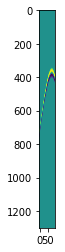

In [28]:
plt.imshow(sigs[:,:,10])
plt.show()

In [8]:
print sigs.shape

(1301, 91, 91)


In [26]:
pfnorm, xf, yf, zf = perfTomog(sigs, xd, t, zTargs*1e-3)

('Reconstructing image with detector row', 91)
('Reconstructing image with detector row', 90)
('Reconstructing image with detector row', 89)
('Reconstructing image with detector row', 88)
('Reconstructing image with detector row', 87)
('Reconstructing image with detector row', 86)
('Reconstructing image with detector row', 85)
('Reconstructing image with detector row', 84)
('Reconstructing image with detector row', 83)
('Reconstructing image with detector row', 82)
('Reconstructing image with detector row', 81)
('Reconstructing image with detector row', 80)
('Reconstructing image with detector row', 79)
('Reconstructing image with detector row', 78)
('Reconstructing image with detector row', 77)
('Reconstructing image with detector row', 76)
('Reconstructing image with detector row', 75)
('Reconstructing image with detector row', 74)
('Reconstructing image with detector row', 73)
('Reconstructing image with detector row', 72)
('Reconstructing image with detector row', 71)
('Reconstruct

In [10]:
print pfnorm.shape

(120, 120, 1)


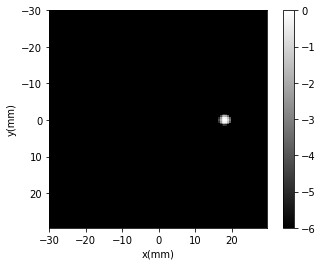

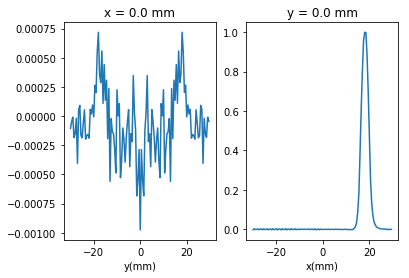

In [27]:
tomPlot2D(pfnorm, xf, yf, 6)